In [153]:
#!pip install -q texttable

In [154]:
from tabulate import tabulate
from texttable import Texttable
import latextable

from SPARQLWrapper import SPARQLWrapper, JSON
from datetime import datetime
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from cdlib import algorithms

In [155]:
def plot_dist(G):
    M = nx.to_scipy_sparse_matrix(G)
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0).A[0]
    degree = np.bincount(indegrees)
    fit = powerlaw.Fit(np.array(degree)+1, fit_method='KS')#, xmin=xmin, xmax=max(degree)-xmin,discrete=True)
    
    
    fig = plt.figure(figsize=(16, 6)) 
    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)),degree,'b.')   
    plt.loglog()
    plt.xlim((min(degree), max(degree)))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')


    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()

In [156]:
def similarita(voti_dep1, voti_dep2):
    uguali = np.sum((voti_dep1 == voti_dep2) & (voti_dep1 != 0) ) # volte in cui hanno votato la stessa  ed erano entrambi presenti

    diversi = np.sum((voti_dep1 != voti_dep2) & (voti_dep1 != 0) & (voti_dep2 != 0) ) # volte in cui hanno votato diversamente ed erano entrambi presenti
    
    if uguali == 0:
        sim = 0
    else:
        sim = uguali/(uguali+diversi)
    return sim

# Load dataset and pre-process, dropping noise rows

In [157]:
year = 2020
y = pd.read_csv(f'./xviii-years/xviii-{year}.csv')
y.shape

(660, 2170)

In [158]:
nan_count = y.isnull().sum(axis=1)
p = 0.8
l = len(y.columns[4:])
df = y.drop(nan_count[nan_count >= p*l].index, axis = 0)

df.shape


(379, 2170)

In [159]:
#mapping to categorical values
dizionario_espressioni = {'Assente': np.float64(0), 'Favorevole': np.float64(1), 'Non ha votato': np.float64(0), 'Contrario': np.float64(3), 'Astensione': np.float64(4), 'In missione': np.float64(0)}
for i in df.columns[4:]:
    df[i] = df[i].map(dizionario_espressioni)

df = df.replace(np.nan, 0)

In [160]:
df.head()

,Parlamentare,id,Partito,dataIngresso,285001,285006,285005,285004,285007,285003,...,446016,446035,446017,446034,446018,446041,446008,446036,446033,446029
0,BASINI GIUSEPPE,200049,LEGA,2018-03-27,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0
1,BERSANI PIER LUIGI,300026,MISTO,2018-03-23,3.0,3.0,1.0,3.0,0.0,3.0,...,3.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0,3.0,3.0
3,MINNITI DOMENICO,300146,PD,2018-03-27,3.0,3.0,1.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FRANCESCHINI DARIO,300246,PD,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,MILANATO LORENA,300296,FI,2018-03-27,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
df.reset_index(inplace= True, drop = True)
indici = []
for i in range(df.shape[0]):
    if np.count_nonzero(df.iloc[i,4:]) < 0.2*(df.shape[1]-4):
        indici.append(i)


df.drop(indici, axis = 0, inplace = True)
df.shape

(278, 2170)

# Extract party alignment for each voting

In [162]:
#works only with dataframes like ours
def alignment_parties(df):
    col = df.columns[4:].to_list()
    col.append('Partito')
    parties_alignment = pd.DataFrame()
    party = df.groupby('Partito')
    for i in party: # party[0] nome partito, party[1] dataframe
        a = np.apply_along_axis(statistics.mode, axis = 0, arr= i[1])[4:].tolist()
        a.append(i[0])
        parties_alignment = pd.concat([parties_alignment, pd.DataFrame(a).T], axis = 0)

    parties_alignment.columns = col
    return parties_alignment


In [163]:
alignment = alignment_parties(df)
alignment

,285001,285006,285005,285004,285007,285003,285002,288011,288010,288003,...,446035,446017,446034,446018,446041,446008,446036,446033,446029,Partito
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,1.0,3.0,0.0,3.0,3.0,3.0,-SI
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CI
0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,FDI
0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,FI
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,IPF-IC
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,IV-IC'E'
0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,1.0,LEGA
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,M5S
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,0.0,3.0,3.0,1.0,0.0,3.0,0.0,3.0,3.0,MISTO
0,3.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,PD


## Partisan discipline

In [164]:
discipline = []
for index, row in df.iterrows():
    p = alignment[alignment['Partito'] == row['Partito']]
    c = 0
    for i in p.drop('Partito', axis = 1).columns:
        if row[i] == np.float64(p[i][0]):
            c+=1
    
    discipline.append(c/(len(p.columns) - 1))

df['discipline'] = discipline

In [165]:
print(df['discipline'].mean(), df['discipline'].std())

0.7089004696519792 0.15276483706201138


# Graph based on similarity

In [166]:
df

,Parlamentare,id,Partito,dataIngresso,285001,285006,285005,285004,285007,285003,...,446035,446017,446034,446018,446041,446008,446036,446033,446029,discipline
0,BASINI GIUSEPPE,200049,LEGA,2018-03-27,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.574331
1,BERSANI PIER LUIGI,300026,MISTO,2018-03-23,3.0,3.0,1.0,3.0,0.0,3.0,...,0.0,3.0,3.0,1.0,0.0,0.0,0.0,3.0,3.0,0.496307
9,GIACHETTI ROBERTO,300480,IV-IC'E',2019-09-19,3.0,3.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.847645
10,BARELLI PAOLO,300497,FI,2018-03-27,0.0,1.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,0.626500
11,BOLDI ROSSANA LIDIA,300506,LEGA,2018-03-27,1.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,FRAILIS ANDREA,308080,PD,2018-03-27,3.0,3.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842567
374,MANTOVANI LUCREZIA MARIA BENEDETTA,308101,FDI,2018-03-27,4.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.795014
375,LOSS MARTINA,308140,LEGA,2018-03-27,1.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.783472
376,BALDINI MARIA TERESA,308181,FI,2018-03-27,4.0,1.0,3.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,0.638966


In [167]:
m = np.array(df[df.columns[4:df.shape[1]-1]])
m.shape

(278, 2166)

In [168]:
A = np.zeros((len(m),len(m))) #inizializzo matrice a 0
i=0
j=0
for i in range(len(m)):
    for j in range(len(m)):
        A[i,j] = similarita(m[i],m[j])

In [169]:
unique_scores, counts = np.unique(A, return_counts=True)
distribution = dict(zip(unique_scores, counts / np.sum(counts)))

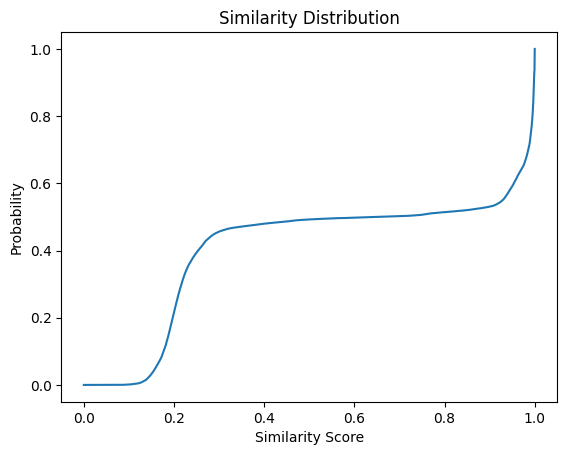

In [170]:
scores = list(distribution.keys())
probabilities = np.cumsum(list(distribution.values()))

plt.plot(scores, probabilities)
plt.xlabel('Similarity Score')
plt.ylabel('Probability')
plt.title('Similarity Distribution')
plt.show()

278
38777
38499
278


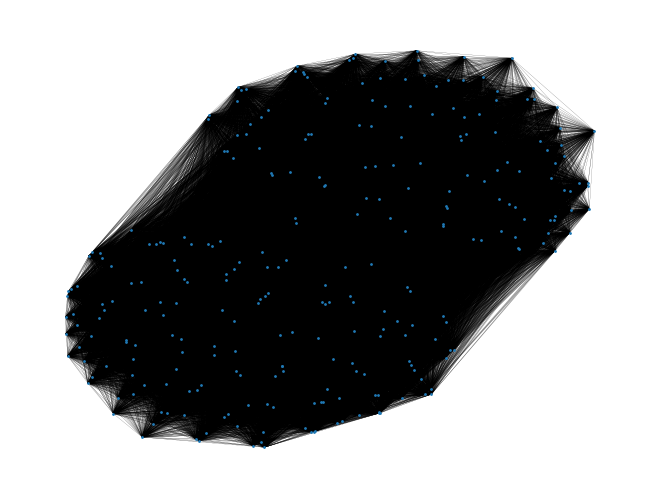

In [171]:
G = nx.from_numpy_matrix(A)

print(G.number_of_nodes())
print(G.number_of_edges())
G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())
print(G.number_of_nodes())

nx.draw(G, node_size = 1, width = 0.1)

38499
19266


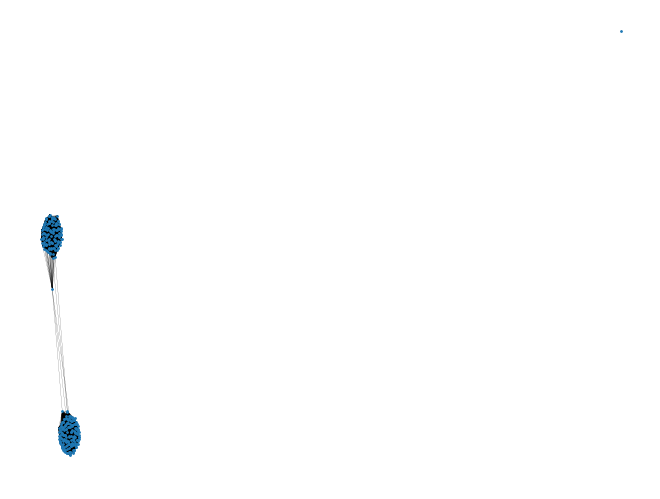

In [172]:
F = G.copy()
threshold = 0.6
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

Degree Distribution Analysis

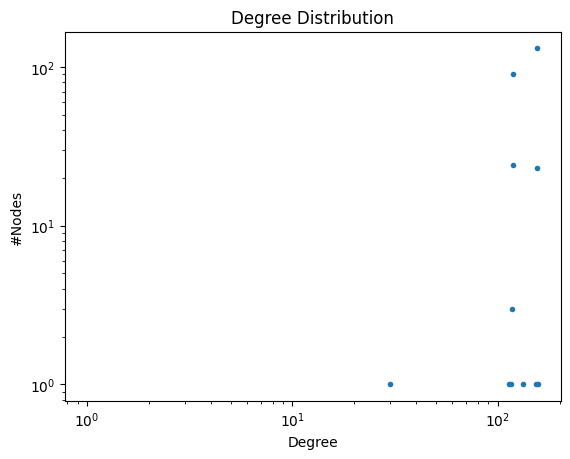

In [173]:
hist = nx.degree_histogram(F)   
plt.plot(range(0, len(hist)), hist, '.')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [174]:
n_nodes = F.number_of_nodes()
n_edges = F.number_of_edges()
avg_deg = sum(dict(F.degree()).values())/float(len(F))
n_comps = nx.number_connected_components(F)
comps = list(nx.connected_components(F)) # get a list of connected components (for decreasing size)
avg_spl = nx.average_shortest_path_length(F.subgraph(comps[0])) #giant component
diam = nx.diameter(F.subgraph(comps[0])) # we compute the diameter on the giant component
avg_cc = nx.average_clustering(F) # compute the global clustering coefficient
density = nx.density(F)

To print the table in Latex:

In [175]:
rows = [['year','#nodes', '#edges', 'avg degree', '#conn. comps.','avg SPL','diameter', 'avg CC', 'Density'],
         [year,n_nodes,n_edges,avg_deg,n_comps, avg_spl, diam, avg_cc,density]]

In [176]:
print('Tabulate Table:')
print(tabulate(rows, headers='firstrow'))

table = Texttable()
table.set_deco(Texttable.HEADER | Texttable.VLINES)
table.add_rows(rows)

print(tabulate(rows, headers='firstrow', tablefmt='latex'))


Tabulate Table:
  year    #nodes    #edges    avg degree    #conn. comps.    avg SPL    diameter    avg CC    Density
------  --------  --------  ------------  ---------------  ---------  ----------  --------  ---------
  2020       278     19266       138.604                2    1.96863           4  0.992635   0.500377
\begin{tabular}{rrrrrrrrr}
\hline
   year &   \#nodes &   \#edges &   avg degree &   \#conn. comps. &   avg SPL &   diameter &   avg CC &   Density \\
\hline
   2020 &      278 &    19266 &      138.604 &               2 &   1.96863 &          4 & 0.992635 &  0.500377 \\
\hline
\end{tabular}


# Comparison with syntetic graphs

# ER

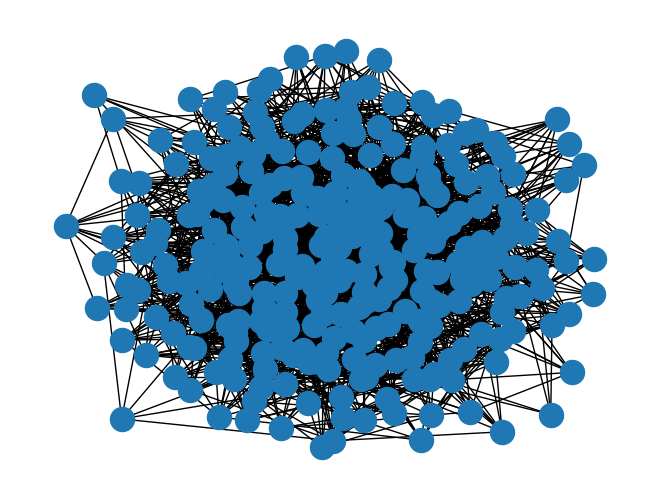

In [177]:
# network generators 1 (random graphs)
p = 0.05 # cambiare p 
er = nx.erdos_renyi_graph(F.number_of_nodes(), p)
nx.draw(er)

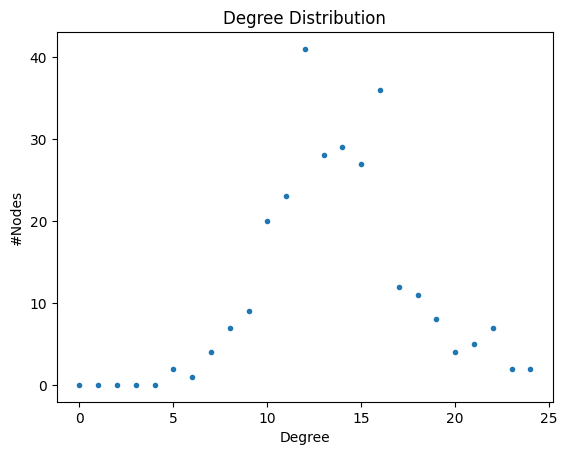

In [178]:
hist = nx.degree_histogram(er)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# BA

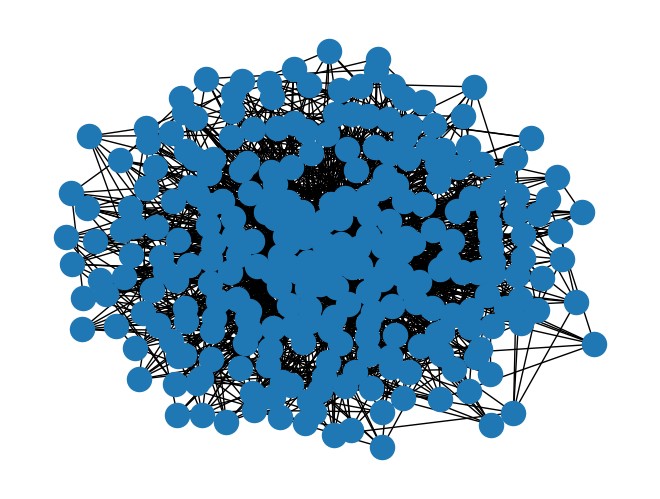

In [179]:
m = 7  # number of links each node establishes once joining the network
ba = nx.barabasi_albert_graph(F.number_of_nodes(), m)
nx.draw(ba)

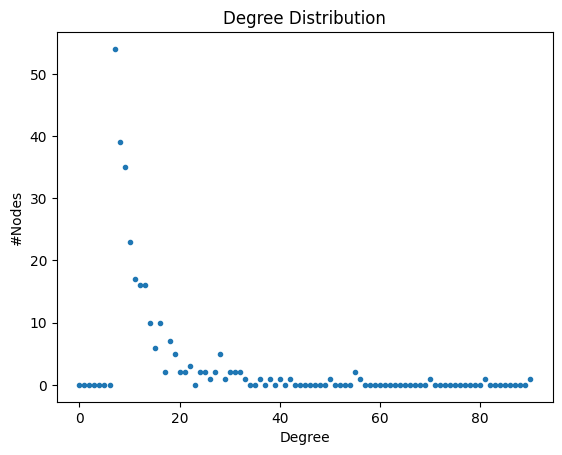

In [180]:
hist = nx.degree_histogram(ba)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

# Prova

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
38499
38499
38450
37237
30183
23295
20870
20290
19962
19704
19472
19354
19265
19178
19083
18937
18628
18394
18000
15644
2309


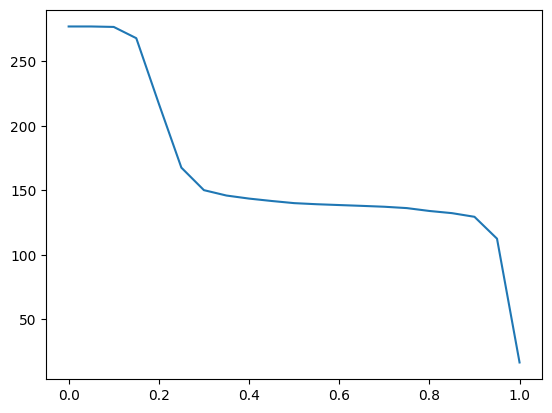

In [181]:
thresholds = np.linspace(0,1, 21)
print(thresholds)
avg_deg = []
n_edg = [] #number of edges

for threshold in thresholds:
    F = G.copy()
    #print(F.number_of_edges())
    F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
    print(F.number_of_edges())
    deg = sum(dict(F.degree()).values())/float(len(G)) #avg degree
    avg_deg.append(deg)
    n_edg.append(F.number_of_edges())
plt.plot(thresholds, avg_deg)
plt.show()
#plt.plot(thresholds, n_edg)
#plt.show()

# Communities

38499
19266


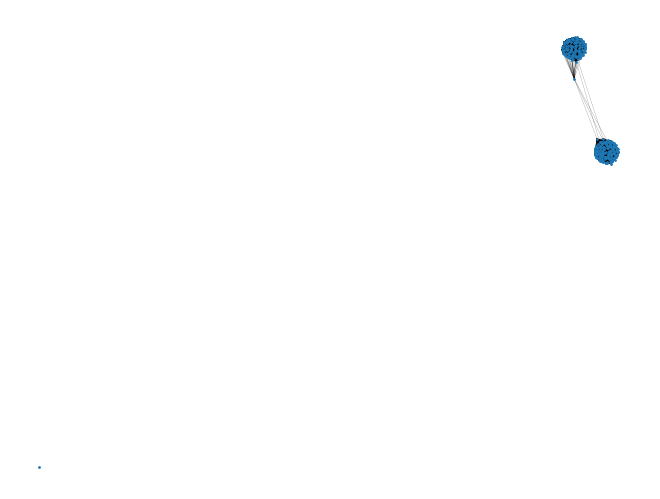

In [182]:
F = G.copy()
threshold = 0.6
print(F.number_of_edges())
F.remove_edges_from([(n1, n2) for n1, n2, w in F.edges(data="weight") if w < threshold])
print(F.number_of_edges())

nx.draw(F, node_size = 1, width = 0.1)
plt.show()

In [183]:
louvain = algorithms.louvain(F)

In [184]:
louvain.communities

[[1,
  2,
  6,
  9,
  14,
  15,
  17,
  19,
  20,
  23,
  24,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  78,
  79,
  80,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  104,
  105,
  107,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  123,
  124,
  125,
  126,
  127,
  130,
  133,
  134,
  136,
  137,
  138,
  139,
  143,
  144,
  147,
  148,
  151,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  173,
  174,
  178,
  179,
  181,
  182,
  183,
  184,
  186,
  190,
  195,
  196,
  198,
  203,
  204,
  205,
  207,
  208,
  209,
  210,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  226,
  229,
  236,
  237,
  241,
  244,
  269,


In [185]:
louvain.average_internal_degree(summary=False)

[155.6687898089172, 117.35, 0.0]

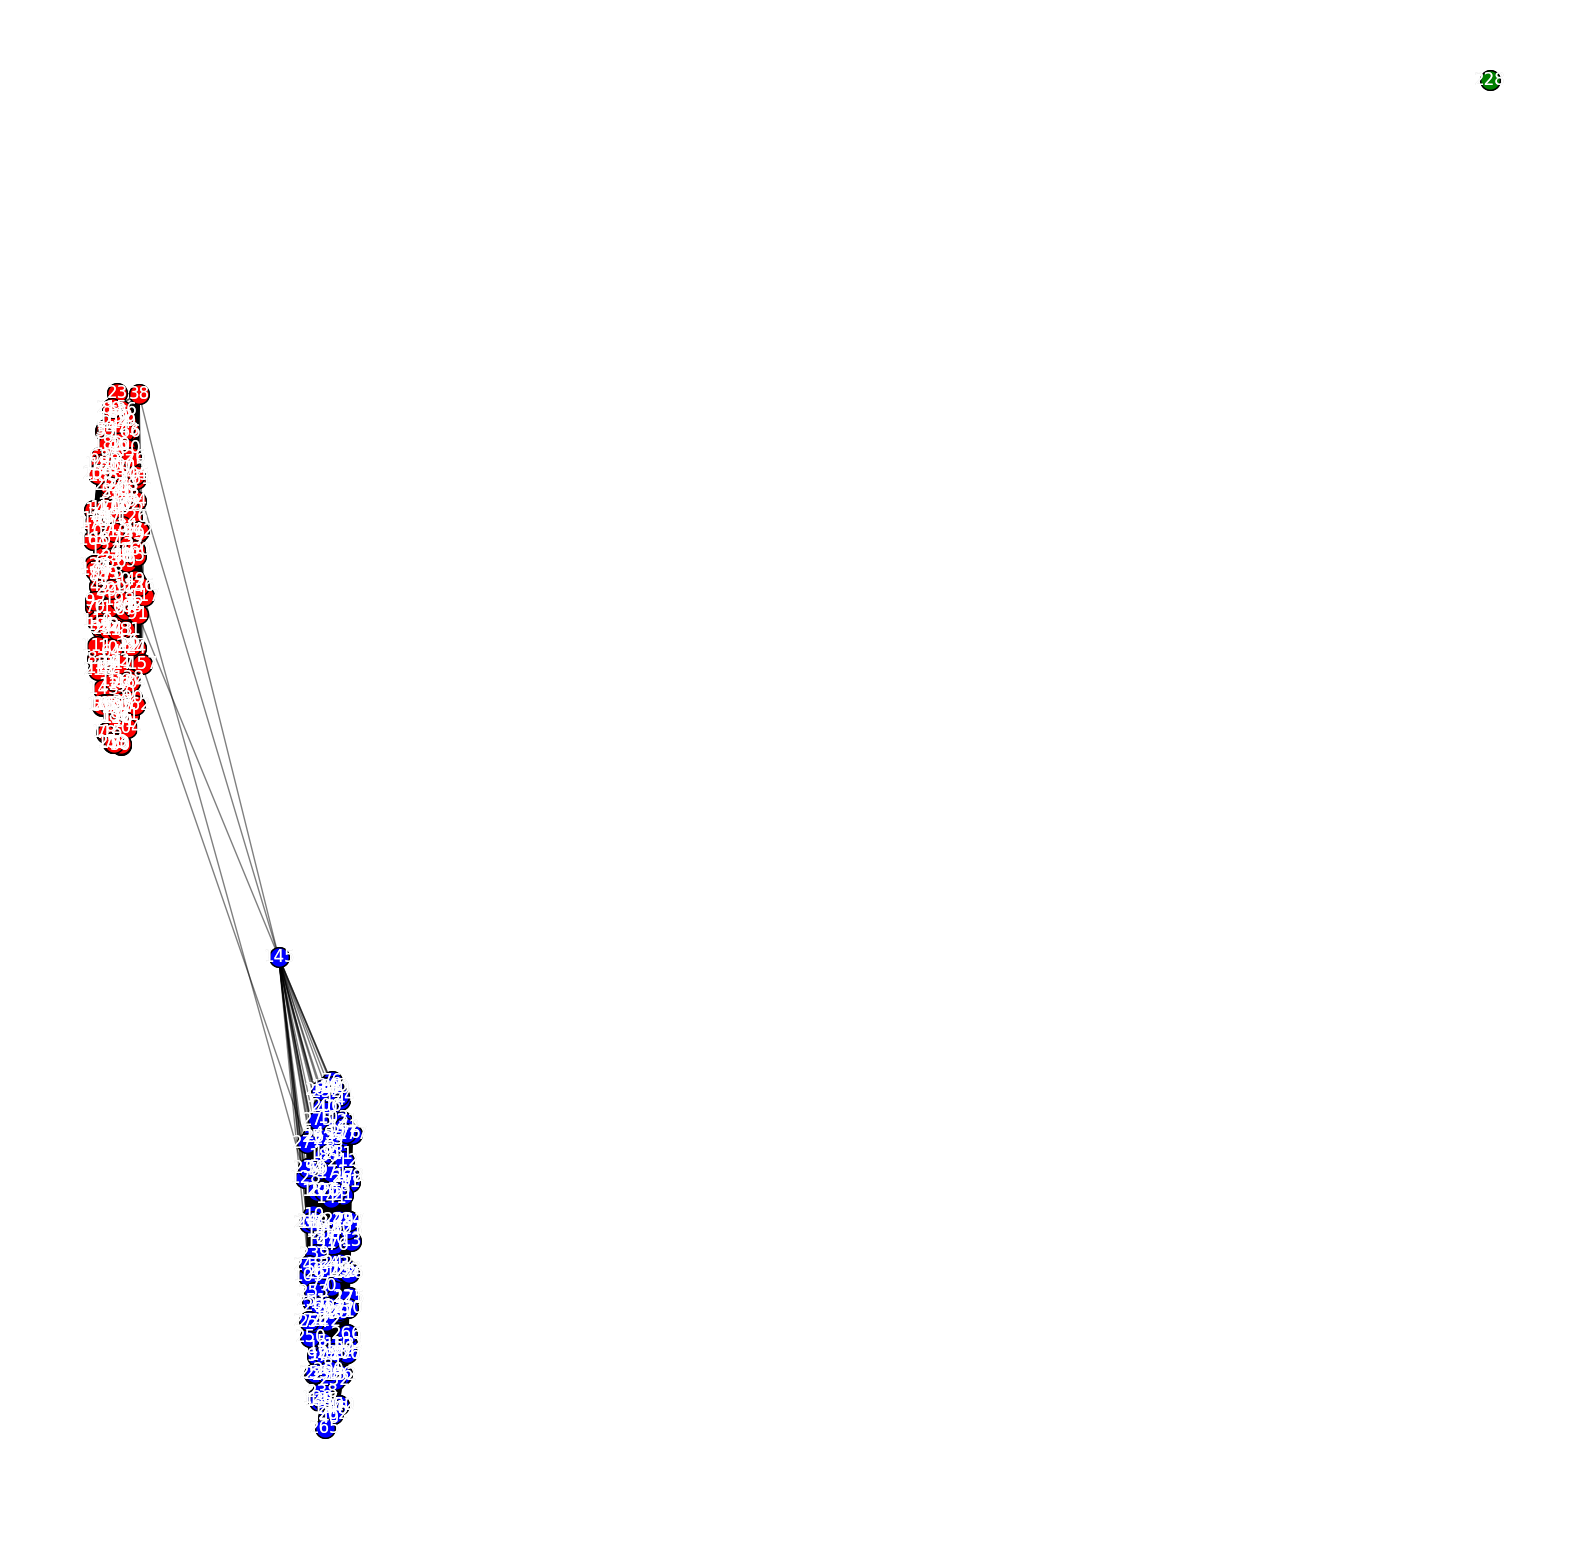

In [186]:
from cdlib import viz

pos = nx.spring_layout(F)
viz.plot_network_clusters(F, louvain, pos, figsize=(20, 20), plot_labels=True)